Our aim is to reproduce an example from the paper:

[Inferring single-trial neural population dynamics using sequential auto-encoders](https://www.nature.com/articles/s41592-018-0109-9)

We will generate trajectories from a latent Lorentz attractor and apply LFADS to recover the latent dynamic. Instead of using the original code (https://lfads.github.io/lfads-run-manager/) we will use tensorflow 2.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import scipy.io
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
import funs

# Sample from latent Lorenz attractor:


In [2]:
Time = 1000
neuron_num = 20
datax = scipy.io.loadmat("spike20_k09_1000.mat")
y_data = datax["x_train"].T
traj = scipy.io.loadmat("trj20_k09_1000.mat")
traj = traj["trj"].T
print(traj.shape)

(1000, 2)


(1000, 20)
[-0.22919868 -0.22879876 -0.20919059 -0.19619371 -0.03163844 -0.12594469
 -0.2345097  -0.27104706 -0.17422637 -0.13184682 -0.37428248 -0.20424037
 -0.3479723  -0.21628922 -0.38631934 -0.09904901 -0.25814083 -0.1563769
 -0.37322313 -0.10492261]


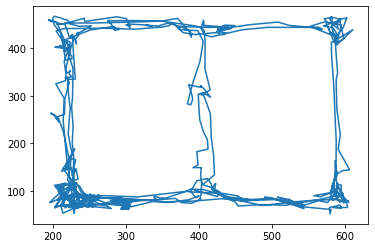

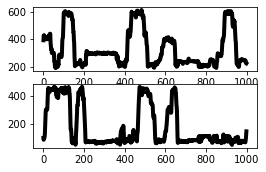

In [3]:
factor_dim = 2
Factor = np.random.randn(factor_dim,neuron_num)

NRep=1
output = np.zeros((NRep,Time,neuron_num))

for i in range(NRep):
    output[i,:,:] = y_data
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(traj[:,0],traj[:,1])
plt.figure(figsize=(4, 4))
ax1 = plt.subplot(311)
ax1.plot(traj[:, 0], lw=4, color='k')

ax2 = plt.subplot(312, sharex=ax1)
ax2.plot(traj[:, 1], lw=4, color='k')    
output = output.astype('float32')

# Z score output:
output=output.reshape(Time*NRep,neuron_num)
print(output.shape)
from scipy import stats
output = stats.zscore(output,axis=0)
output = output.reshape(NRep,Time,neuron_num)
print(output[0,1])

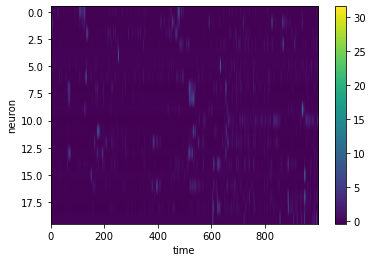

In [4]:
plt.figure()
plt.imshow(output[0,:,:].T,aspect='auto')
plt.xlabel('time')
plt.ylabel('neuron')
plt.colorbar()
plt.show()

In [5]:
# Create Tensorflow Dataset
dataset = tf.data.Dataset.from_tensor_slices((output))
dataset = dataset.shuffle(15, reshuffle_each_iteration=True)

# Autoencoder Model

In [6]:
tf.keras.backend.clear_session()

In [7]:
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [8]:
class Encoder(tf.keras.layers.Layer):
    """Maps Trajectory to a triplet (z_mean, z_log_var, z)."""
    def __init__(self,
                 latent_dim=64,
                 num_gru_unit=64,
                 sequence_length=Time,
                 num_input_neuron=neuron_num,
                 name='encoder',
                 **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)        
        self.bidir_gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(num_gru_unit,return_sequences=False), 
                                                       input_shape=(sequence_length, num_input_neuron))
        self.dense_mean = tf.keras.layers.Dense(latent_dim)
        self.dense_log_var = tf.keras.layers.Dense(latent_dim)
        self.sampling = Sampling()
        
    def call(self, inputs):
        x = self.bidir_gru(inputs)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z

In [9]:
class Decoder(tf.keras.layers.Layer):
    """Converts z, the encoded digit vector, back into a readable digit."""
    def __init__(self,
                 latent_dim=64,
                 sequence_length=Time,
                 num_input_neuron=neuron_num,
                 num_factor=2,
                 name='decoder',
                 **kwargs):
        self.sequence_length = sequence_length
        super(Decoder, self).__init__(name=name, **kwargs)
        self.recurrent_decoder = tf.keras.layers.GRU(latent_dim,return_sequences=True)#,use_bias=False)
        self.linear_bottleneck = tf.keras.layers.Dense(num_factor, activation=None)
        self.dense_output = tf.keras.layers.Dense(num_input_neuron, activation=None)
        self.latent_dim=latent_dim
        
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        null_input = tf.zeros([batch_size,self.sequence_length,self.latent_dim])
        decoder_output = self.recurrent_decoder(null_input, initial_state=inputs)
        x = self.linear_bottleneck(decoder_output)
        xo = self.dense_output(x)
        return xo, x

In [10]:
class VariationalAutoEncoder(tf.keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""
    def __init__(self,
                 latent_dim=64,
                 num_gru_unit=64,
                 sequence_length=Time,
                 num_input_neuron=neuron_num,
                 num_factor=2,
                 name='autoencoder',
                 **kwargs):
        super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
        self.encoder = Encoder(latent_dim=latent_dim,num_gru_unit=num_gru_unit,sequence_length=sequence_length,
                               num_input_neuron=num_input_neuron)
        self.decoder = Decoder(latent_dim=latent_dim, sequence_length=sequence_length,
                              num_input_neuron=num_input_neuron,num_factor=num_factor)
    
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)[0]
        # Add KL divergence regularization loss.
        kl_loss = - 0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)
        return reconstructed
    def latent(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        latent = self.decoder(z)[1]
        return latent

In [11]:
BATCH_SIZE = 128
batched_dataset = dataset.batch(BATCH_SIZE)

In [12]:
vae = VariationalAutoEncoder(latent_dim=64,
                             num_gru_unit=128,
                             sequence_length=Time,
                             num_input_neuron=neuron_num,
                             num_factor=2)

# Train Model

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3,clipvalue=200)
mse_loss_fn = tf.keras.losses.MeanSquaredError()
loss_metric = tf.keras.metrics.Mean()

#### Linearly scheduling on the Kullback–Leibler divergence penalty:

We use a linearly increasing schedule on the Kullback–Leibler divergence penalty (as suggested [here](https://arxiv.org/pdf/1511.06349.pdf)) so that the optimization does not quickly (and pathologically) set the Kullback–Leibler divergence to 0


In [14]:
KL_penalty = np.linspace(0,1,2)

In [15]:
epochs = 100
for i,kl_ in enumerate(KL_penalty):
    
    # Iterate over epochs.
    for epoch in range(epochs):
        print('Start of epoch %d' % (epoch,))

        # Iterate over the batches of the dataset.
        for step, x_batch_train in enumerate(batched_dataset):
            with tf.GradientTape() as tape:
                reconstructed = vae(x_batch_train)
                # Compute reconstruction loss
                loss = mse_loss_fn(x_batch_train, reconstructed)
                loss += kl_*sum(vae.losses)  # Add KLD regularization loss

            grads = tape.gradient(loss, vae.trainable_weights)
            optimizer.apply_gradients(zip(grads, vae.trainable_weights))
            loss_metric(loss)

            if step % 100 == 0:
                print('step %s: mean loss = %s' % (step, loss_metric.result().numpy()))

Start of epoch 0
step 0: mean loss = 1.0010095
Start of epoch 1
step 0: mean loss = 1.0005271
Start of epoch 2
step 0: mean loss = 1.0004071
Start of epoch 3
step 0: mean loss = 1.0002617
Start of epoch 4
step 0: mean loss = 1.0001867
Start of epoch 5
step 0: mean loss = 1.0001446
Start of epoch 6
step 0: mean loss = 1.0001861
Start of epoch 7
step 0: mean loss = 1.000217
Start of epoch 8
step 0: mean loss = 1.0001696
Start of epoch 9
step 0: mean loss = 1.0001228
Start of epoch 10
step 0: mean loss = 1.0000852
Start of epoch 11
step 0: mean loss = 1.0000731
Start of epoch 12
step 0: mean loss = 1.0000482
Start of epoch 13
step 0: mean loss = 1.0000316
Start of epoch 14
step 0: mean loss = 1.0000155
Start of epoch 15
step 0: mean loss = 0.99999523
Start of epoch 16
step 0: mean loss = 0.9999917
Start of epoch 17
step 0: mean loss = 0.999974
Start of epoch 18
step 0: mean loss = 0.99996614
Start of epoch 19
step 0: mean loss = 0.9999517
Start of epoch 20
step 0: mean loss = 0.99993885
S

step 0: mean loss = 0.99834615
Start of epoch 170
step 0: mean loss = 0.9983264
Start of epoch 171
step 0: mean loss = 0.9983063
Start of epoch 172
step 0: mean loss = 0.998286
Start of epoch 173
step 0: mean loss = 0.99826574
Start of epoch 174
step 0: mean loss = 0.99824524
Start of epoch 175
step 0: mean loss = 0.9982246
Start of epoch 176
step 0: mean loss = 0.9982039
Start of epoch 177
step 0: mean loss = 0.9981834
Start of epoch 178
step 0: mean loss = 0.9981626
Start of epoch 179
step 0: mean loss = 0.9981417
Start of epoch 180
step 0: mean loss = 0.9981208
Start of epoch 181
step 0: mean loss = 0.99810004
Start of epoch 182
step 0: mean loss = 0.9980791
Start of epoch 183
step 0: mean loss = 0.9980585
Start of epoch 184
step 0: mean loss = 0.9980377
Start of epoch 185
step 0: mean loss = 0.9980171
Start of epoch 186
step 0: mean loss = 0.99799645
Start of epoch 187
step 0: mean loss = 0.997976
Start of epoch 188
step 0: mean loss = 0.99795556
Start of epoch 189
step 0: mean los

step 0: mean loss = 0.9956623
Start of epoch 337
step 0: mean loss = 0.9956509
Start of epoch 338
step 0: mean loss = 0.9956395
Start of epoch 339
step 0: mean loss = 0.9956282
Start of epoch 340
step 0: mean loss = 0.9956169
Start of epoch 341
step 0: mean loss = 0.9956057
Start of epoch 342
step 0: mean loss = 0.9955945
Start of epoch 343
step 0: mean loss = 0.99558336
Start of epoch 344
step 0: mean loss = 0.99557227
Start of epoch 345
step 0: mean loss = 0.9955612
Start of epoch 346
step 0: mean loss = 0.99555016
Start of epoch 347
step 0: mean loss = 0.9955392
Start of epoch 348
step 0: mean loss = 0.9955283
Start of epoch 349
step 0: mean loss = 0.9955173
Start of epoch 350
step 0: mean loss = 0.99550647
Start of epoch 351
step 0: mean loss = 0.9954956
Start of epoch 352
step 0: mean loss = 0.9954849
Start of epoch 353
step 0: mean loss = 0.9954741
Start of epoch 354
step 0: mean loss = 0.9954634
Start of epoch 355
step 0: mean loss = 0.9954527
Start of epoch 356
step 0: mean los

step 0: mean loss = 0.9941967
Start of epoch 503
step 0: mean loss = 0.99418986
Start of epoch 504
step 0: mean loss = 0.99418306
Start of epoch 505
step 0: mean loss = 0.9941762
Start of epoch 506
step 0: mean loss = 0.9941694
Start of epoch 507
step 0: mean loss = 0.9941626
Start of epoch 508
step 0: mean loss = 0.9941558
Start of epoch 509
step 0: mean loss = 0.99414915
Start of epoch 510
step 0: mean loss = 0.9941424
Start of epoch 511
step 0: mean loss = 0.99413574
Start of epoch 512
step 0: mean loss = 0.99412906
Start of epoch 513
step 0: mean loss = 0.9941224
Start of epoch 514
step 0: mean loss = 0.9941157
Start of epoch 515
step 0: mean loss = 0.99410915
Start of epoch 516
step 0: mean loss = 0.9941026
Start of epoch 517
step 0: mean loss = 0.994096
Start of epoch 518
step 0: mean loss = 0.99408937
Start of epoch 519
step 0: mean loss = 0.99408275
Start of epoch 520
step 0: mean loss = 0.9940762
Start of epoch 521
step 0: mean loss = 0.99406964
Start of epoch 522
step 0: mean

step 0: mean loss = 0.99327374
Start of epoch 670
step 0: mean loss = 0.9932692
Start of epoch 671
step 0: mean loss = 0.9932647
Start of epoch 672
step 0: mean loss = 0.9932602
Start of epoch 673
step 0: mean loss = 0.99325573
Start of epoch 674
step 0: mean loss = 0.9932512
Start of epoch 675
step 0: mean loss = 0.9932468
Start of epoch 676
step 0: mean loss = 0.9932423
Start of epoch 677
step 0: mean loss = 0.99323785
Start of epoch 678
step 0: mean loss = 0.99323344
Start of epoch 679
step 0: mean loss = 0.993229
Start of epoch 680
step 0: mean loss = 0.99322444
Start of epoch 681
step 0: mean loss = 0.99322
Start of epoch 682
step 0: mean loss = 0.99321556
Start of epoch 683
step 0: mean loss = 0.993211
Start of epoch 684
step 0: mean loss = 0.9932065
Start of epoch 685
step 0: mean loss = 0.993202
Start of epoch 686
step 0: mean loss = 0.9931974
Start of epoch 687
step 0: mean loss = 0.99319273
Start of epoch 688
step 0: mean loss = 0.9931881
Start of epoch 689
step 0: mean loss 

step 0: mean loss = 0.9915341
Start of epoch 837
step 0: mean loss = 0.99151945
Start of epoch 838
step 0: mean loss = 0.9915049
Start of epoch 839
step 0: mean loss = 0.99149036
Start of epoch 840
step 0: mean loss = 0.9914758
Start of epoch 841
step 0: mean loss = 0.99146116
Start of epoch 842
step 0: mean loss = 0.99144644
Start of epoch 843
step 0: mean loss = 0.99143165
Start of epoch 844
step 0: mean loss = 0.9914168
Start of epoch 845
step 0: mean loss = 0.99140185
Start of epoch 846
step 0: mean loss = 0.9913868
Start of epoch 847
step 0: mean loss = 0.99137163
Start of epoch 848
step 0: mean loss = 0.9913566
Start of epoch 849
step 0: mean loss = 0.99134153
Start of epoch 850
step 0: mean loss = 0.9913266
Start of epoch 851
step 0: mean loss = 0.9913116
Start of epoch 852
step 0: mean loss = 0.9912969
Start of epoch 853
step 0: mean loss = 0.9912825
Start of epoch 854
step 0: mean loss = 0.9912686
Start of epoch 855
step 0: mean loss = 0.99125457
Start of epoch 856
step 0: mea

step 0: mean loss = 0.98930013
Start of epoch 1003
step 0: mean loss = 0.9892882
Start of epoch 1004
step 0: mean loss = 0.98927695
Start of epoch 1005
step 0: mean loss = 0.98926586
Start of epoch 1006
step 0: mean loss = 0.9892549
Start of epoch 1007
step 0: mean loss = 0.98924303
Start of epoch 1008
step 0: mean loss = 0.9892308
Start of epoch 1009
step 0: mean loss = 0.98921865
Start of epoch 1010
step 0: mean loss = 0.98920673
Start of epoch 1011
step 0: mean loss = 0.98919535
Start of epoch 1012
step 0: mean loss = 0.9891841
Start of epoch 1013
step 0: mean loss = 0.9891728
Start of epoch 1014
step 0: mean loss = 0.98916095
Start of epoch 1015
step 0: mean loss = 0.9891488
Start of epoch 1016
step 0: mean loss = 0.9891368
Start of epoch 1017
step 0: mean loss = 0.9891253
Start of epoch 1018
step 0: mean loss = 0.9891145
Start of epoch 1019
step 0: mean loss = 0.9891032
Start of epoch 1020
step 0: mean loss = 0.9890914
Start of epoch 1021
step 0: mean loss = 0.98907936
Start of ep

step 0: mean loss = 0.98754525
Start of epoch 1166
step 0: mean loss = 0.9875351
Start of epoch 1167
step 0: mean loss = 0.987525
Start of epoch 1168
step 0: mean loss = 0.9875149
Start of epoch 1169
step 0: mean loss = 0.9875048
Start of epoch 1170
step 0: mean loss = 0.9874948
Start of epoch 1171
step 0: mean loss = 0.987485
Start of epoch 1172
step 0: mean loss = 0.98747545
Start of epoch 1173
step 0: mean loss = 0.9874667
Start of epoch 1174
step 0: mean loss = 0.9874582
Start of epoch 1175
step 0: mean loss = 0.9874498
Start of epoch 1176
step 0: mean loss = 0.9874402
Start of epoch 1177
step 0: mean loss = 0.9874303
Start of epoch 1178
step 0: mean loss = 0.9874203
Start of epoch 1179
step 0: mean loss = 0.98741084
Start of epoch 1180
step 0: mean loss = 0.9874021
Start of epoch 1181
step 0: mean loss = 0.9873935
Start of epoch 1182
step 0: mean loss = 0.98738486
Start of epoch 1183
step 0: mean loss = 0.98737544
Start of epoch 1184
step 0: mean loss = 0.98736554
Start of epoch 1

step 0: mean loss = 0.986113
Start of epoch 1329
step 0: mean loss = 0.98610526
Start of epoch 1330
step 0: mean loss = 0.9860982
Start of epoch 1331
step 0: mean loss = 0.986092
Start of epoch 1332
step 0: mean loss = 0.98608464
Start of epoch 1333
step 0: mean loss = 0.98607665
Start of epoch 1334
step 0: mean loss = 0.9860684
Start of epoch 1335
step 0: mean loss = 0.9860602
Start of epoch 1336
step 0: mean loss = 0.9860521
Start of epoch 1337
step 0: mean loss = 0.9860442
Start of epoch 1338
step 0: mean loss = 0.9860365
Start of epoch 1339
step 0: mean loss = 0.98602897
Start of epoch 1340
step 0: mean loss = 0.9860215
Start of epoch 1341
step 0: mean loss = 0.9860141
Start of epoch 1342
step 0: mean loss = 0.98600674
Start of epoch 1343
step 0: mean loss = 0.98599917
Start of epoch 1344
step 0: mean loss = 0.9859914
Start of epoch 1345
step 0: mean loss = 0.98598343
Start of epoch 1346
step 0: mean loss = 0.98597527
Start of epoch 1347
step 0: mean loss = 0.9859671
Start of epoch

step 0: mean loss = 0.9855856
Start of epoch 1492
step 0: mean loss = 0.985592
Start of epoch 1493
step 0: mean loss = 0.9855984
Start of epoch 1494
step 0: mean loss = 0.9856047
Start of epoch 1495
step 0: mean loss = 0.9856109
Start of epoch 1496
step 0: mean loss = 0.98561704
Start of epoch 1497
step 0: mean loss = 0.98562324
Start of epoch 1498
step 0: mean loss = 0.9856293
Start of epoch 1499
step 0: mean loss = 0.9856354
Start of epoch 1500
step 0: mean loss = 0.9856415
Start of epoch 1501
step 0: mean loss = 0.98564756
Start of epoch 1502
step 0: mean loss = 0.9856535
Start of epoch 1503
step 0: mean loss = 0.9856595
Start of epoch 1504
step 0: mean loss = 0.98566544
Start of epoch 1505
step 0: mean loss = 0.9856714
Start of epoch 1506
step 0: mean loss = 0.98567736
Start of epoch 1507
step 0: mean loss = 0.98568326
Start of epoch 1508
step 0: mean loss = 0.9856892
Start of epoch 1509
step 0: mean loss = 0.98569506
Start of epoch 1510
step 0: mean loss = 0.9857009
Start of epoch

step 0: mean loss = 0.98642594
Start of epoch 1655
step 0: mean loss = 0.9864303
Start of epoch 1656
step 0: mean loss = 0.98643464
Start of epoch 1657
step 0: mean loss = 0.986439
Start of epoch 1658
step 0: mean loss = 0.98644334
Start of epoch 1659
step 0: mean loss = 0.9864477
Start of epoch 1660
step 0: mean loss = 0.98645204
Start of epoch 1661
step 0: mean loss = 0.9864563
Start of epoch 1662
step 0: mean loss = 0.98646057
Start of epoch 1663
step 0: mean loss = 0.9864648
Start of epoch 1664
step 0: mean loss = 0.98646903
Start of epoch 1665
step 0: mean loss = 0.98647326
Start of epoch 1666
step 0: mean loss = 0.9864775
Start of epoch 1667
step 0: mean loss = 0.9864817
Start of epoch 1668
step 0: mean loss = 0.98648596
Start of epoch 1669
step 0: mean loss = 0.9864902
Start of epoch 1670
step 0: mean loss = 0.98649436
Start of epoch 1671
step 0: mean loss = 0.9864986
Start of epoch 1672
step 0: mean loss = 0.9865028
Start of epoch 1673
step 0: mean loss = 0.986507
Start of epoc

step 0: mean loss = 0.98702353
Start of epoch 1818
step 0: mean loss = 0.98702663
Start of epoch 1819
step 0: mean loss = 0.98702973
Start of epoch 1820
step 0: mean loss = 0.9870329
Start of epoch 1821
step 0: mean loss = 0.98703593
Start of epoch 1822
step 0: mean loss = 0.98703897
Start of epoch 1823
step 0: mean loss = 0.987042
Start of epoch 1824
step 0: mean loss = 0.98704505
Start of epoch 1825
step 0: mean loss = 0.98704803
Start of epoch 1826
step 0: mean loss = 0.98705107
Start of epoch 1827
step 0: mean loss = 0.98705405
Start of epoch 1828
step 0: mean loss = 0.9870571
Start of epoch 1829
step 0: mean loss = 0.98706007
Start of epoch 1830
step 0: mean loss = 0.9870631
Start of epoch 1831
step 0: mean loss = 0.9870661
Start of epoch 1832
step 0: mean loss = 0.9870691
Start of epoch 1833
step 0: mean loss = 0.98707205
Start of epoch 1834
step 0: mean loss = 0.98707503
Start of epoch 1835
step 0: mean loss = 0.987078
Start of epoch 1836
step 0: mean loss = 0.987081
Start of ep

step 0: mean loss = 0.98746324
Start of epoch 1981
step 0: mean loss = 0.9874656
Start of epoch 1982
step 0: mean loss = 0.987468
Start of epoch 1983
step 0: mean loss = 0.9874704
Start of epoch 1984
step 0: mean loss = 0.9874728
Start of epoch 1985
step 0: mean loss = 0.98747516
Start of epoch 1986
step 0: mean loss = 0.9874775
Start of epoch 1987
step 0: mean loss = 0.98747987
Start of epoch 1988
step 0: mean loss = 0.98748225
Start of epoch 1989
step 0: mean loss = 0.9874846
Start of epoch 1990
step 0: mean loss = 0.98748696
Start of epoch 1991
step 0: mean loss = 0.98748934
Start of epoch 1992
step 0: mean loss = 0.98749167
Start of epoch 1993
step 0: mean loss = 0.98749405
Start of epoch 1994
step 0: mean loss = 0.9874964
Start of epoch 1995
step 0: mean loss = 0.98749876
Start of epoch 1996
step 0: mean loss = 0.9875011
Start of epoch 1997
step 0: mean loss = 0.9875034
Start of epoch 1998
step 0: mean loss = 0.9875058
Start of epoch 1999
step 0: mean loss = 0.9875081
Start of epo

step 0: mean loss = 1.0711685
Start of epoch 151
step 0: mean loss = 1.0711355
Start of epoch 152
step 0: mean loss = 1.071102
Start of epoch 153
step 0: mean loss = 1.0710685
Start of epoch 154
step 0: mean loss = 1.0710346
Start of epoch 155
step 0: mean loss = 1.0710014
Start of epoch 156
step 0: mean loss = 1.070968
Start of epoch 157
step 0: mean loss = 1.0709349
Start of epoch 158
step 0: mean loss = 1.0709016
Start of epoch 159
step 0: mean loss = 1.0708688
Start of epoch 160
step 0: mean loss = 1.070835
Start of epoch 161
step 0: mean loss = 1.070804
Start of epoch 162
step 0: mean loss = 1.0707716
Start of epoch 163
step 0: mean loss = 1.0707387
Start of epoch 164
step 0: mean loss = 1.070706
Start of epoch 165
step 0: mean loss = 1.0706736
Start of epoch 166
step 0: mean loss = 1.0706412
Start of epoch 167
step 0: mean loss = 1.070608
Start of epoch 168
step 0: mean loss = 1.0705744
Start of epoch 169
step 0: mean loss = 1.0705411
Start of epoch 170
step 0: mean loss = 1.0705

step 0: mean loss = 1.0659369
Start of epoch 319
step 0: mean loss = 1.065907
Start of epoch 320
step 0: mean loss = 1.0658773
Start of epoch 321
step 0: mean loss = 1.065848
Start of epoch 322
step 0: mean loss = 1.0658187
Start of epoch 323
step 0: mean loss = 1.0657893
Start of epoch 324
step 0: mean loss = 1.0657607
Start of epoch 325
step 0: mean loss = 1.0657314
Start of epoch 326
step 0: mean loss = 1.0657028
Start of epoch 327
step 0: mean loss = 1.0656738
Start of epoch 328
step 0: mean loss = 1.0656446
Start of epoch 329
step 0: mean loss = 1.0656157
Start of epoch 330
step 0: mean loss = 1.065587
Start of epoch 331
step 0: mean loss = 1.0655586
Start of epoch 332
step 0: mean loss = 1.0655305
Start of epoch 333
step 0: mean loss = 1.0655026
Start of epoch 334
step 0: mean loss = 1.0654751
Start of epoch 335
step 0: mean loss = 1.0654463
Start of epoch 336
step 0: mean loss = 1.0654169
Start of epoch 337
step 0: mean loss = 1.065388
Start of epoch 338
step 0: mean loss = 1.06

step 0: mean loss = 1.0613638
Start of epoch 487
step 0: mean loss = 1.0613383
Start of epoch 488
step 0: mean loss = 1.0613128
Start of epoch 489
step 0: mean loss = 1.0612869
Start of epoch 490
step 0: mean loss = 1.061261
Start of epoch 491
step 0: mean loss = 1.0612355
Start of epoch 492
step 0: mean loss = 1.0612098
Start of epoch 493
step 0: mean loss = 1.0611848
Start of epoch 494
step 0: mean loss = 1.0611595
Start of epoch 495
step 0: mean loss = 1.0611352
Start of epoch 496
step 0: mean loss = 1.0611091
Start of epoch 497
step 0: mean loss = 1.0610836
Start of epoch 498
step 0: mean loss = 1.0610589
Start of epoch 499
step 0: mean loss = 1.0610332
Start of epoch 500
step 0: mean loss = 1.0610077
Start of epoch 501
step 0: mean loss = 1.0609823
Start of epoch 502
step 0: mean loss = 1.0609568
Start of epoch 503
step 0: mean loss = 1.060931
Start of epoch 504
step 0: mean loss = 1.0609056
Start of epoch 505
step 0: mean loss = 1.06088
Start of epoch 506
step 0: mean loss = 1.06

step 0: mean loss = 1.05732
Start of epoch 655
step 0: mean loss = 1.057297
Start of epoch 656
step 0: mean loss = 1.0572746
Start of epoch 657
step 0: mean loss = 1.057252
Start of epoch 658
step 0: mean loss = 1.0572298
Start of epoch 659
step 0: mean loss = 1.0572075
Start of epoch 660
step 0: mean loss = 1.0571843
Start of epoch 661
step 0: mean loss = 1.0571612
Start of epoch 662
step 0: mean loss = 1.0571388
Start of epoch 663
step 0: mean loss = 1.0571169
Start of epoch 664
step 0: mean loss = 1.0570946
Start of epoch 665
step 0: mean loss = 1.0570719
Start of epoch 666
step 0: mean loss = 1.0570494
Start of epoch 667
step 0: mean loss = 1.0570267
Start of epoch 668
step 0: mean loss = 1.0570035
Start of epoch 669
step 0: mean loss = 1.056981
Start of epoch 670
step 0: mean loss = 1.0569584
Start of epoch 671
step 0: mean loss = 1.0569355
Start of epoch 672
step 0: mean loss = 1.0569136
Start of epoch 673
step 0: mean loss = 1.0568924
Start of epoch 674
step 0: mean loss = 1.056

step 0: mean loss = 1.0537306
Start of epoch 823
step 0: mean loss = 1.0537099
Start of epoch 824
step 0: mean loss = 1.0536897
Start of epoch 825
step 0: mean loss = 1.0536696
Start of epoch 826
step 0: mean loss = 1.0536501
Start of epoch 827
step 0: mean loss = 1.0536304
Start of epoch 828
step 0: mean loss = 1.05361
Start of epoch 829
step 0: mean loss = 1.0535893
Start of epoch 830
step 0: mean loss = 1.0535693
Start of epoch 831
step 0: mean loss = 1.053549
Start of epoch 832
step 0: mean loss = 1.0535288
Start of epoch 833
step 0: mean loss = 1.0535085
Start of epoch 834
step 0: mean loss = 1.053488
Start of epoch 835
step 0: mean loss = 1.053468
Start of epoch 836
step 0: mean loss = 1.0534482
Start of epoch 837
step 0: mean loss = 1.0534282
Start of epoch 838
step 0: mean loss = 1.0534077
Start of epoch 839
step 0: mean loss = 1.0533878
Start of epoch 840
step 0: mean loss = 1.0533677
Start of epoch 841
step 0: mean loss = 1.0533491
Start of epoch 842
step 0: mean loss = 1.053

step 0: mean loss = 1.0505114
Start of epoch 991
step 0: mean loss = 1.0504935
Start of epoch 992
step 0: mean loss = 1.050475
Start of epoch 993
step 0: mean loss = 1.0504564
Start of epoch 994
step 0: mean loss = 1.0504384
Start of epoch 995
step 0: mean loss = 1.0504205
Start of epoch 996
step 0: mean loss = 1.0504019
Start of epoch 997
step 0: mean loss = 1.0503843
Start of epoch 998
step 0: mean loss = 1.0503663
Start of epoch 999
step 0: mean loss = 1.0503483
Start of epoch 1000
step 0: mean loss = 1.0503303
Start of epoch 1001
step 0: mean loss = 1.050312
Start of epoch 1002
step 0: mean loss = 1.050294
Start of epoch 1003
step 0: mean loss = 1.0502757
Start of epoch 1004
step 0: mean loss = 1.0502573
Start of epoch 1005
step 0: mean loss = 1.0502393
Start of epoch 1006
step 0: mean loss = 1.0502205
Start of epoch 1007
step 0: mean loss = 1.0502031
Start of epoch 1008
step 0: mean loss = 1.0501845
Start of epoch 1009
step 0: mean loss = 1.0501662
Start of epoch 1010
step 0: mean

step 0: mean loss = 1.0476527
Start of epoch 1156
step 0: mean loss = 1.0476362
Start of epoch 1157
step 0: mean loss = 1.0476205
Start of epoch 1158
step 0: mean loss = 1.0476038
Start of epoch 1159
step 0: mean loss = 1.0475869
Start of epoch 1160
step 0: mean loss = 1.0475702
Start of epoch 1161
step 0: mean loss = 1.047554
Start of epoch 1162
step 0: mean loss = 1.0475377
Start of epoch 1163
step 0: mean loss = 1.0475209
Start of epoch 1164
step 0: mean loss = 1.0475041
Start of epoch 1165
step 0: mean loss = 1.0474877
Start of epoch 1166
step 0: mean loss = 1.0474719
Start of epoch 1167
step 0: mean loss = 1.0474557
Start of epoch 1168
step 0: mean loss = 1.0474399
Start of epoch 1169
step 0: mean loss = 1.0474237
Start of epoch 1170
step 0: mean loss = 1.0474069
Start of epoch 1171
step 0: mean loss = 1.0473906
Start of epoch 1172
step 0: mean loss = 1.0473745
Start of epoch 1173
step 0: mean loss = 1.0473579
Start of epoch 1174
step 0: mean loss = 1.0473422
Start of epoch 1175
s

step 0: mean loss = 1.045041
Start of epoch 1321
step 0: mean loss = 1.0450263
Start of epoch 1322
step 0: mean loss = 1.0450114
Start of epoch 1323
step 0: mean loss = 1.0449966
Start of epoch 1324
step 0: mean loss = 1.0449811
Start of epoch 1325
step 0: mean loss = 1.0449657
Start of epoch 1326
step 0: mean loss = 1.044951
Start of epoch 1327
step 0: mean loss = 1.0449365
Start of epoch 1328
step 0: mean loss = 1.044922
Start of epoch 1329
step 0: mean loss = 1.0449077
Start of epoch 1330
step 0: mean loss = 1.0448924
Start of epoch 1331
step 0: mean loss = 1.0448773
Start of epoch 1332
step 0: mean loss = 1.0448623
Start of epoch 1333
step 0: mean loss = 1.044847
Start of epoch 1334
step 0: mean loss = 1.0448325
Start of epoch 1335
step 0: mean loss = 1.0448173
Start of epoch 1336
step 0: mean loss = 1.0448029
Start of epoch 1337
step 0: mean loss = 1.0447885
Start of epoch 1338
step 0: mean loss = 1.0447733
Start of epoch 1339
step 0: mean loss = 1.0447588
Start of epoch 1340
step

step 0: mean loss = 1.0426561
Start of epoch 1486
step 0: mean loss = 1.0426419
Start of epoch 1487
step 0: mean loss = 1.0426282
Start of epoch 1488
step 0: mean loss = 1.0426147
Start of epoch 1489
step 0: mean loss = 1.0426012
Start of epoch 1490
step 0: mean loss = 1.0425882
Start of epoch 1491
step 0: mean loss = 1.0425742
Start of epoch 1492
step 0: mean loss = 1.0425607
Start of epoch 1493
step 0: mean loss = 1.0425476
Start of epoch 1494
step 0: mean loss = 1.0425335
Start of epoch 1495
step 0: mean loss = 1.0425195
Start of epoch 1496
step 0: mean loss = 1.0425062
Start of epoch 1497
step 0: mean loss = 1.0424929
Start of epoch 1498
step 0: mean loss = 1.0424789
Start of epoch 1499
step 0: mean loss = 1.042465
Start of epoch 1500
step 0: mean loss = 1.0424507
Start of epoch 1501
step 0: mean loss = 1.0424366
Start of epoch 1502
step 0: mean loss = 1.0424223
Start of epoch 1503
step 0: mean loss = 1.0424091
Start of epoch 1504
step 0: mean loss = 1.0423952
Start of epoch 1505
s

step 0: mean loss = 1.0404656
Start of epoch 1651
step 0: mean loss = 1.0404533
Start of epoch 1652
step 0: mean loss = 1.0404407
Start of epoch 1653
step 0: mean loss = 1.0404276
Start of epoch 1654
step 0: mean loss = 1.0404147
Start of epoch 1655
step 0: mean loss = 1.0404018
Start of epoch 1656
step 0: mean loss = 1.040389
Start of epoch 1657
step 0: mean loss = 1.040376
Start of epoch 1658
step 0: mean loss = 1.0403632
Start of epoch 1659
step 0: mean loss = 1.0403502
Start of epoch 1660
step 0: mean loss = 1.0403373
Start of epoch 1661
step 0: mean loss = 1.0403249
Start of epoch 1662
step 0: mean loss = 1.0403126
Start of epoch 1663
step 0: mean loss = 1.0402997
Start of epoch 1664
step 0: mean loss = 1.0402868
Start of epoch 1665
step 0: mean loss = 1.0402737
Start of epoch 1666
step 0: mean loss = 1.040261
Start of epoch 1667
step 0: mean loss = 1.0402485
Start of epoch 1668
step 0: mean loss = 1.0402359
Start of epoch 1669
step 0: mean loss = 1.0402235
Start of epoch 1670
ste

step 0: mean loss = 1.0383172
Start of epoch 1816
step 0: mean loss = 1.0383025
Start of epoch 1817
step 0: mean loss = 1.0382879
Start of epoch 1818
step 0: mean loss = 1.0382731
Start of epoch 1819
step 0: mean loss = 1.0382582
Start of epoch 1820
step 0: mean loss = 1.0382434
Start of epoch 1821
step 0: mean loss = 1.0382288
Start of epoch 1822
step 0: mean loss = 1.0382144
Start of epoch 1823
step 0: mean loss = 1.0381994
Start of epoch 1824
step 0: mean loss = 1.0381849
Start of epoch 1825
step 0: mean loss = 1.0381702
Start of epoch 1826
step 0: mean loss = 1.0381552
Start of epoch 1827
step 0: mean loss = 1.03814
Start of epoch 1828
step 0: mean loss = 1.0381255
Start of epoch 1829
step 0: mean loss = 1.0381107
Start of epoch 1830
step 0: mean loss = 1.0380956
Start of epoch 1831
step 0: mean loss = 1.0380808
Start of epoch 1832
step 0: mean loss = 1.0380656
Start of epoch 1833
step 0: mean loss = 1.0380511
Start of epoch 1834
step 0: mean loss = 1.0380359
Start of epoch 1835
st

step 0: mean loss = 1.0360316
Start of epoch 1981
step 0: mean loss = 1.0360187
Start of epoch 1982
step 0: mean loss = 1.036006
Start of epoch 1983
step 0: mean loss = 1.0359929
Start of epoch 1984
step 0: mean loss = 1.0359795
Start of epoch 1985
step 0: mean loss = 1.035966
Start of epoch 1986
step 0: mean loss = 1.0359524
Start of epoch 1987
step 0: mean loss = 1.0359391
Start of epoch 1988
step 0: mean loss = 1.0359253
Start of epoch 1989
step 0: mean loss = 1.0359114
Start of epoch 1990
step 0: mean loss = 1.0358973
Start of epoch 1991
step 0: mean loss = 1.0358833
Start of epoch 1992
step 0: mean loss = 1.0358706
Start of epoch 1993
step 0: mean loss = 1.0358566
Start of epoch 1994
step 0: mean loss = 1.0358428
Start of epoch 1995
step 0: mean loss = 1.035829
Start of epoch 1996
step 0: mean loss = 1.0358155
Start of epoch 1997
step 0: mean loss = 1.0358013
Start of epoch 1998
step 0: mean loss = 1.0357872
Start of epoch 1999
step 0: mean loss = 1.0357733


# Evaluate Quality of reconstruction 

(1, 1000, 20)
(1, 1000, 2)
(1000, 2)
(1000, 2)


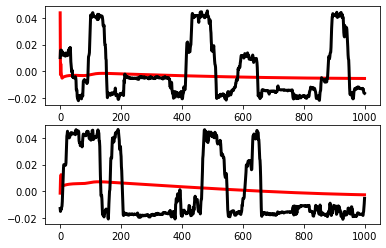

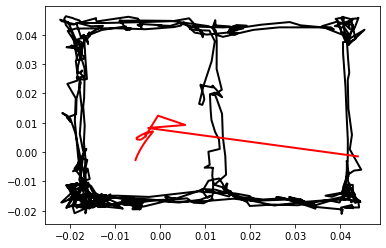

In [16]:
for x in batched_dataset.take(1):
    print(x.shape)
    qz_mean_est = vae.latent(x)
    print(qz_mean_est.shape)

qz_est_norm = np.stack(qz_mean_est)/np.linalg.norm(np.stack(qz_mean_est))
print(qz_est_norm[0].shape)

z_true_c = traj - traj.mean(axis=0)
z_true_norm = z_true_c/np.linalg.norm(z_true_c)
print(z_true_norm.shape)
R = funs.compute_optimal_rotation(np.stack(qz_est_norm[0]), z_true_norm, scale=True)
qz_est_norm_R = np.stack(qz_est_norm).dot(R)

from scipy import signal
#qz_est_norm_R[:,0] = signal.savgol_filter(qz_est_norm_R[:,0], 51, 5)
#qz_est_norm_R[:,1] = signal.savgol_filter(qz_est_norm_R[:,1],51, 5)
plt.subplot(211)
plt_post = plt.plot(qz_est_norm_R[0,:,0],'r', linewidth = 3, label = 'posterior mean')
plt_true = plt.plot(z_true_norm[:,0], 'k', linewidth = 3, label = '\"true\" mean')
plt.subplot(212)
plt_post = plt.plot(qz_est_norm_R[0,:,1],'r', linewidth = 3, label = 'posterior mean')
plt_true = plt.plot(z_true_norm[:,1], 'k', linewidth = 3, label = '\"true\" mean')

fig = plt.figure()
plt.plot(z_true_norm[:,0], z_true_norm[:,1], lw=2, color = 'k')
plt.plot(qz_est_norm_R[0,:,0], qz_est_norm_R[0,:,1], lw=2, color = 'r')